# IA651 - Machine Learning
## Cancer prediction using Lifestyle Attributes
### By - Kranthi Chaithanya Thota and Vishal Singarapu
#### Under the guidance of professor Michael Gilbert (mgilbert@clarkson.edu)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lime.lime_tabular import LimeTabularExplainer
from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv("LLCP2022.csv", encoding="utf-8")

In [3]:
df = df.drop(columns= ["Unnamed: 0"])
df = df.drop_duplicates()

df.head()

_STATE  FMONTH    IDATE  IMONTH  IDAY  IYEAR  DISPCODE       SEQNO  \
0     1.0     1.0  2032022       2     3   2022    1100.0  2022000001   
1     1.0     1.0  2042022       2     4   2022    1100.0  2022000002   
2     1.0     1.0  2022022       2     2   2022    1100.0  2022000003   
3     1.0     1.0  2032022       2     3   2022    1100.0  2022000004   
4     1.0     1.0  2022022       2     2   2022    1100.0  2022000005   

           _PSU  CTELENM1  ...  _SMOKGRP  _LCSREC  DRNKANY6  DROCDY4_  \
0  2.022000e+09       1.0  ...       4.0      NaN       2.0       0.0   
1  2.022000e+09       1.0  ...       4.0      NaN       2.0       0.0   
2  2.022000e+09       1.0  ...       4.0      NaN       2.0       0.0   
3  2.022000e+09       1.0  ...       3.0      2.0       2.0       0.0   
4  2.022000e+09       1.0  ...       4.0      NaN       1.0      10.0   

   _RFBING6  _DRNKWK2  _RFDRHV8  _FLSHOT7  _PNEUMO3  _AIDTST4  
0       1.0       0.0       1.0       1.0       2.0       2.0  
1       1.0       0.0       1.0       2.0       2.0       2.0  
2       1.0       0.0       1.0       NaN       NaN       2.0  
3       1.0       0.0       1.0       9.0       9.0       2.0  
4       1.0     140.0       1.0       NaN       NaN       2.0  

[5 rows x 328 columns]

In [4]:
df.shape

(445132, 328)

In [5]:
select_cols = ['_ASTHMS1','_SEX','_AGE_G',
                 '_BMI5CAT', 'EDUCA', '_INCOMG1', '_SMOKER3', 'PNEUVAC4','PHYSHLTH',
                 'MENTHLTH', '_HLTHPLN', '_TOTINDA', 'DIABETE4','CHCCOPD3','DECIDE','_RFDRHV8','_PRACE2',
                 'ADDEPEV3', 'IYEAR', 'IMONTH', 'IDAY','_STATE','SMOKDAY2',
                 'AVEDRNK3','CHCSCNC1','CHCOCNC1']

Mapping variables into respective labels for exploratory data analysis.

In [6]:
df_selected = df.copy()

state_mapping = {
    1: "AL", 2: "AK", 4: "AZ", 5: "AR", 6: "CA", 20: "KS", 34: "NJ", 48: "TX",
    21: "KY", 35: "NM", 49: "UT", 8: "CO", 22: "LA", 36: "NY", 50: "VT",
    9: "CT", 23: "ME", 37: "NC", 51: "VA", 10: "DE", 24: "MD", 38: "ND", 66: "GU",
    11: "DC", 25: "MA", 39: "OH", 53: "WA", 12: "FL", 26: "MI", 40: "OK", 54: "WV",
    13: "GA", 27: "MN", 41: "OR", 55: "WI", 28: "MS", 42: "PA", 56: "WY",
    15: "HI", 29: "MO", 16: "ID", 30: "MT", 44: "RI", 72: "PR",
    17: "IL", 31: "NE", 45: "SC", 18: "IN", 32: "NV", 46: "SD", 19: "IA", 33: "NH",
    47: "TN", 78: "VI"
}

df_selected['_STATE'] = df_selected['_STATE'].astype(int)
df_selected['STATE_CODE'] = df_selected['_STATE'].map(state_mapping)
df_selected['GENDER'] = df_selected['_SEX'].replace({1: 'MALE', 2: 'FEMALE'})
df_selected['INCOME_GRP'] = df_selected['_INCOMG1'].replace({
    1: 'Less than $15000', 2: '$15000 to less than $25000', 3: '$25000 to less than $35000',
    4: '$35000 to less than $50000', 5: '$50000 or $100000', 6: '$100000 to $200000',
    7: '$200000 or more', 9: None
}).fillna('No Income')
df_selected['EDUCATION_CATEGORY'] = df_selected['EDUCA'].replace({
    1: "Never attended school",
    2: 'Grades 1 through 8', 3: 'Grades 9 through 11', 4: 'Grades 12 or High School Graduate',
    5: 'College 1 year to 3 years', 6: 'College 4 years or more', 9: None
}).fillna('Never attended school')
df_selected['HAS_HLTHCOVRGE'] = np.where(df_selected['_HLTHPLN'] == 1, "Yes", "No")
df_selected['ASTHMA_STATUS'] = df_selected['_ASTHMS1'].replace({
    1: "Current", 2: "Former", 3: "Never", 9: None
}).fillna("Never")
df_selected['AGE_CATEGORY'] = df_selected['_AGE_G'].replace({
    1: 'AGE 18-24', 2: 'AGE 25-34', 3: 'AGE 35-44', 4: 'AGE 45-54', 5: 'AGE 55-64',
    6: 'AGE 65 or older'
})
df_selected['BMI_CATEGORY'] = df_selected['_BMI5CAT'].replace({
    1: 'Underweight', 2: 'Normal Weight', 3: 'Overweight', 4: 'Obese'
}).fillna('Normal Weight')
df_selected['HEAVY_SMOKER'] = np.where(df_selected['_SMOKER3'].isin([1, 2]), "Yes", "No")
df_selected['RACE'] = df_selected['_PRACE2'].replace({
    1: 'White', 2: 'African American', 3: 'Alaskan Native',
    4: 'Asian', 5: 'Native Hawaiian', 7: 'Multiracial', 77: None,
    88: None, 99: None
}).fillna('Other Race')
df_selected['HEAVY_DRINKER'] = np.where(df_selected['_RFDRHV8'] == 2, "Yes", "No")
df_selected['HAS_DEPRESSION'] = np.where(df_selected['ADDEPEV3'] == 1, "Yes", "No")
df_selected['HAD_PNEU_VACC'] = np.where(df_selected['PNEUVAC4'] == 1 , "Yes", "No")
df_selected['EXERCISE'] = np.where(df_selected['_TOTINDA'] == 1, "Yes", "No")
df_selected['HAS_PREDIABETES'] = np.where(df_selected['DIABETE4'].isin([1,2]), "Yes", "No")
df_selected['MEMORY_LOSS'] = np.where(df_selected["DECIDE"] == 1, "Yes", "No")
df_selected['HAS_CANCER'] = np.where(((df_selected['CHCOCNC1'] == 1) | (df_selected['CHCSCNC1'] == 1)), "Yes", "No")
df_selected['BADPHYSHLTH_PAST30DAYS'] = np.where(df_selected['PHYSHLTH'].fillna(0).astype(int).isin([88, 77, 99]) | df_selected['PHYSHLTH'].isnull(), 0, df_selected['PHYSHLTH'].fillna(0).astype(int))
df_selected['BADMENTHLTH_PAST30DAYS'] = np.where(df_selected['MENTHLTH'].fillna(0).astype(int).isin([88, 77, 99]) | df_selected['MENTHLTH'].isnull(), 0, df_selected['MENTHLTH'].fillna(0).astype(int))
df_selected['SMOKE_FREQ'] = df_selected["SMOKDAY2"].replace({
    1: "High", 2: "Medium", 3: "Low", 7: "No", 9: "No"
}).fillna("No")
df_selected['ACG_ALC'] = np.where((df_selected['AVEDRNK3'] >= 1) & (df_selected['AVEDRNK3'] < 77), df_selected['AVEDRNK3'], 0)
df_selected['YEAR'] = df_selected['IYEAR'].astype(str).str.strip().replace('b', '')
df_selected['MONTH'] = df_selected['IMONTH'].astype(str).str.strip().replace('b', '')
df_selected['DAY'] = df_selected['IDAY'].astype(str).str.strip().replace('b', '')
df_selected['YEARMO'] = df_selected['YEAR'] + df_selected['MONTH']

In [7]:
df_selected

_STATE  FMONTH     IDATE  IMONTH  IDAY  IYEAR  DISPCODE       SEQNO  \
0            1     1.0   2032022       2     3   2022    1100.0  2022000001   
1            1     1.0   2042022       2     4   2022    1100.0  2022000002   
2            1     1.0   2022022       2     2   2022    1100.0  2022000003   
3            1     1.0   2032022       2     3   2022    1100.0  2022000004   
4            1     1.0   2022022       2     2   2022    1100.0  2022000005   
...        ...     ...       ...     ...   ...    ...       ...         ...   
445127      78    11.0  12192022      12    19   2022    1100.0  2022001527   
445128      78    11.0  12212022      12    21   2022    1100.0  2022001528   
445129      78    11.0  11292022      11    29   2022    1100.0  2022001529   
445130      78    11.0  12082022      12     8   2022    1100.0  2022001530   
445131      78    11.0  12142022      12    14   2022    1100.0  2022001531   

                _PSU  CTELENM1  ...  MEMORY_LOSS  HAS_CANCER  \
0       2.022000e+09       1.0  ...           No          No   
1       2.022000e+09       1.0  ...           No         Yes   
2       2.022000e+09       1.0  ...           No         Yes   
3       2.022000e+09       1.0  ...           No          No   
4       2.022000e+09       1.0  ...           No          No   
...              ...       ...  ...          ...         ...   
445127  2.022002e+09       NaN  ...           No          No   
445128  2.022002e+09       NaN  ...           No          No   
445129  2.022002e+09       NaN  ...           No          No   
445130  2.022002e+09       NaN  ...           No          No   
445131  2.022002e+09       NaN  ...          Yes          No   

        BADPHYSHLTH_PAST30DAYS  BADMENTHLTH_PAST30DAYS  SMOKE_FREQ  ACG_ALC  \
0                            0                       0          No      0.0   
1                            0                       0          No      0.0   
2                            2                       3          No      0.0   
3                            0                       0      Medium      0.0   
4                            2                       0          No      2.0   
...                        ...                     ...         ...      ...   
445127                       0                       3          No      0.0   
445128                       2                       2          No      0.0   
445129                      30                      30        High      0.0   
445130                       0                       0          No      0.0   
445131                       0                       1         Low      0.0   

        YEAR  MONTH  DAY  YEARMO  
0       2022      2    3   20222  
1       2022      2    4   20222  
2       2022      2    2   20222  
3       2022      2    3   20222  
4       2022      2    2   20222  
...      ...    ...  ...     ...  
445127  2022     12   19  202212  
445128  2022     12   21  202212  
445129  2022     11   29  202211  
445130  2022     12    8  202212  
445131  2022     12   14  202212  

[445132 rows x 353 columns]

In [8]:
mapped_variables = [
    'STATE_CODE','GENDER', 'INCOME_GRP', 'EDUCATION_CATEGORY', 'HAS_HLTHCOVRGE',
    'ASTHMA_STATUS', 'AGE_CATEGORY', 'BMI_CATEGORY',
    'RACE', 'HAS_DEPRESSION', 'HAD_PNEU_VACC',
    'EXERCISE', 'HAS_PREDIABETES', 'MEMORY_LOSS', 'HAS_CANCER',
    'BADPHYSHLTH_PAST30DAYS', 'BADMENTHLTH_PAST30DAYS', 'SMOKE_FREQ',
    'ACG_ALC', 'YEAR', 'MONTH', 'DAY', 'YEARMO', 'HEAVY_DRINKER'
]

eda_df = df_selected[mapped_variables]
eda_df['YEARMO'] = eda_df['YEARMO'].str.replace(" ", "0").str.replace("'", "").astype(int)
print(eda_df.head())

  STATE_CODE  GENDER                  INCOME_GRP  \
0         AL  FEMALE                   No Income   
1         AL  FEMALE  $25000 to less than $35000   
2         AL  FEMALE          $100000 to $200000   
3         AL  FEMALE                   No Income   
4         AL  FEMALE  $25000 to less than $35000   

                  EDUCATION_CATEGORY HAS_HLTHCOVRGE ASTHMA_STATUS  \
0            College 4 years or more             No         Never   
1  Grades 12 or High School Graduate            Yes         Never   
2            College 4 years or more            Yes         Never   
3  Grades 12 or High School Graduate             No       Current   
4          College 1 year to 3 years            Yes         Never   

      AGE_CATEGORY   BMI_CATEGORY   RACE HAS_DEPRESSION  ... HAS_CANCER  \
0  AGE 65 or older  Normal Weight  White             No  ...         No   
1  AGE 65 or older     Overweight  White             No  ...        Yes   
2        AGE 55-64     Overweight  White       

C:\Users\thota\AppData\Local\Temp\ipykernel_19260\3797293955.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_df['YEARMO'] = eda_df['YEARMO'].str.replace(" ", "0").str.replace("'", "").astype(int)


In [9]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   STATE_CODE              445132 non-null  object 
 1   GENDER                  445132 non-null  object 
 2   INCOME_GRP              445132 non-null  object 
 3   EDUCATION_CATEGORY      445132 non-null  object 
 4   HAS_HLTHCOVRGE          445132 non-null  object 
 5   ASTHMA_STATUS           445132 non-null  object 
 6   AGE_CATEGORY            445132 non-null  object 
 7   BMI_CATEGORY            445132 non-null  object 
 8   RACE                    445132 non-null  object 
 9   HAS_DEPRESSION          445132 non-null  object 
 10  HAD_PNEU_VACC           445132 non-null  object 
 11  EXERCISE                445132 non-null  object 
 12  HAS_PREDIABETES         445132 non-null  object 
 13  MEMORY_LOSS             445132 non-null  object 
 14  HAS_CANCER          

In [10]:
eda_df.drop(columns=['YEARMO']).describe()

BADPHYSHLTH_PAST30DAYS  BADMENTHLTH_PAST30DAYS        ACG_ALC
count           445132.000000           445132.000000  445132.000000
mean                 4.241187                4.293378       1.046539
std                  8.607936                8.324664       1.948651
min                  0.000000                0.000000       0.000000
25%                  0.000000                0.000000       0.000000
50%                  0.000000                0.000000       0.000000
75%                  3.000000                4.000000       2.000000
max                 30.000000               30.000000      76.000000

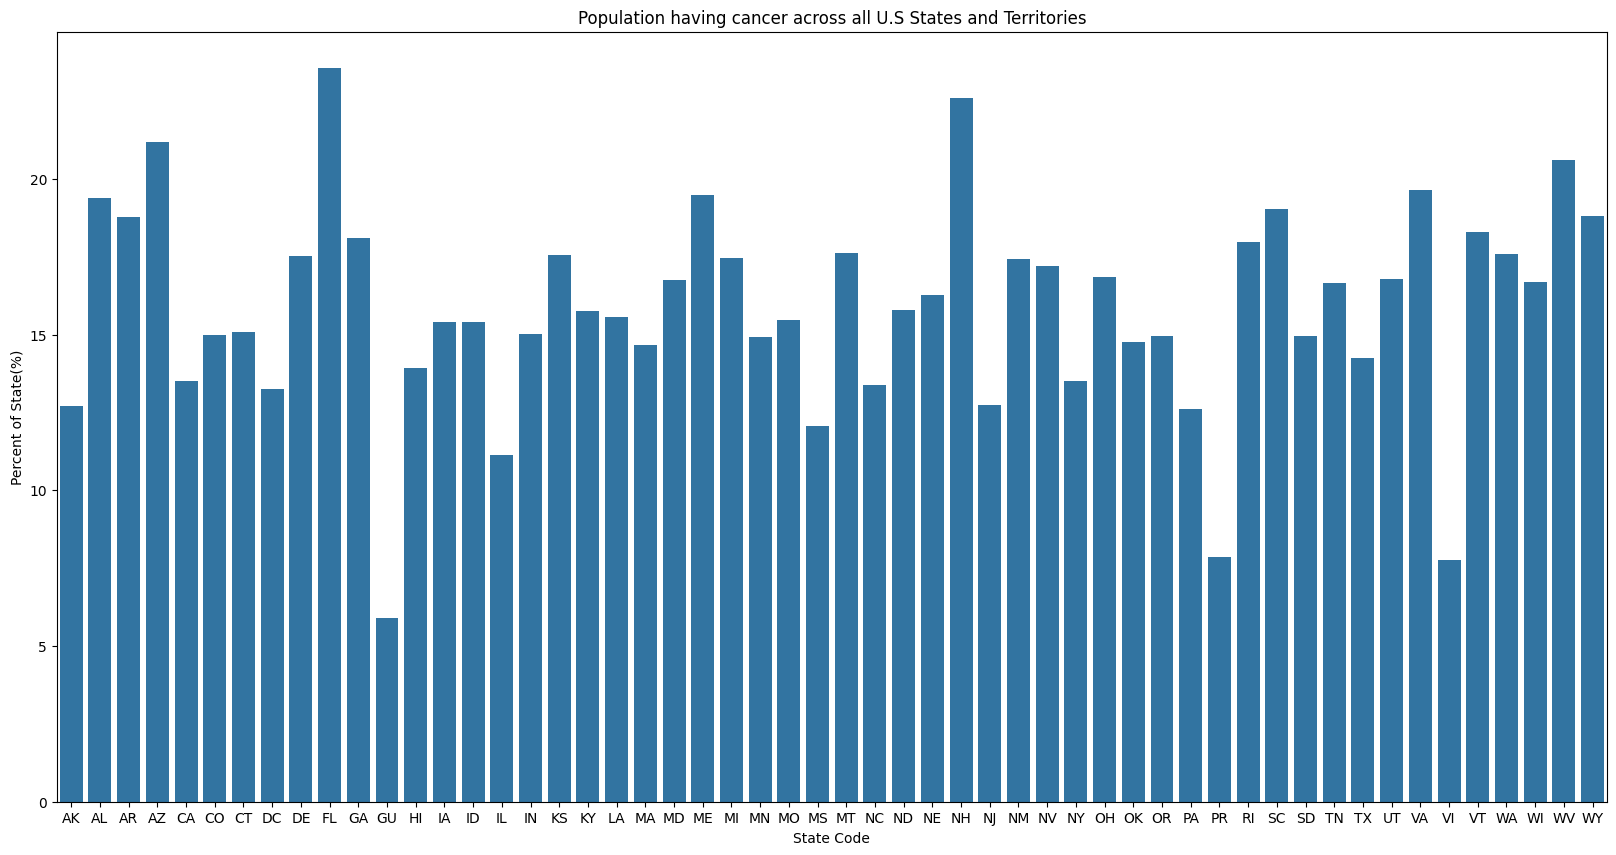

In [11]:
cancer_df = eda_df[eda_df['HAS_CANCER'] == "Yes"]
state_counts = cancer_df['STATE_CODE'].value_counts()
total_counts = eda_df['STATE_CODE'].value_counts()
percentage_df = (state_counts / total_counts * 100).reset_index()
percentage_df.columns = ['STATE_CODE', 'Percentage']
plt.figure(figsize=(20, 10))
sns.barplot(x='STATE_CODE', y='Percentage', data=percentage_df)
plt.title('Population having cancer across all U.S States and Territories')
plt.xlabel('State Code')
plt.ylabel('Percent of State(%)')
plt.show()

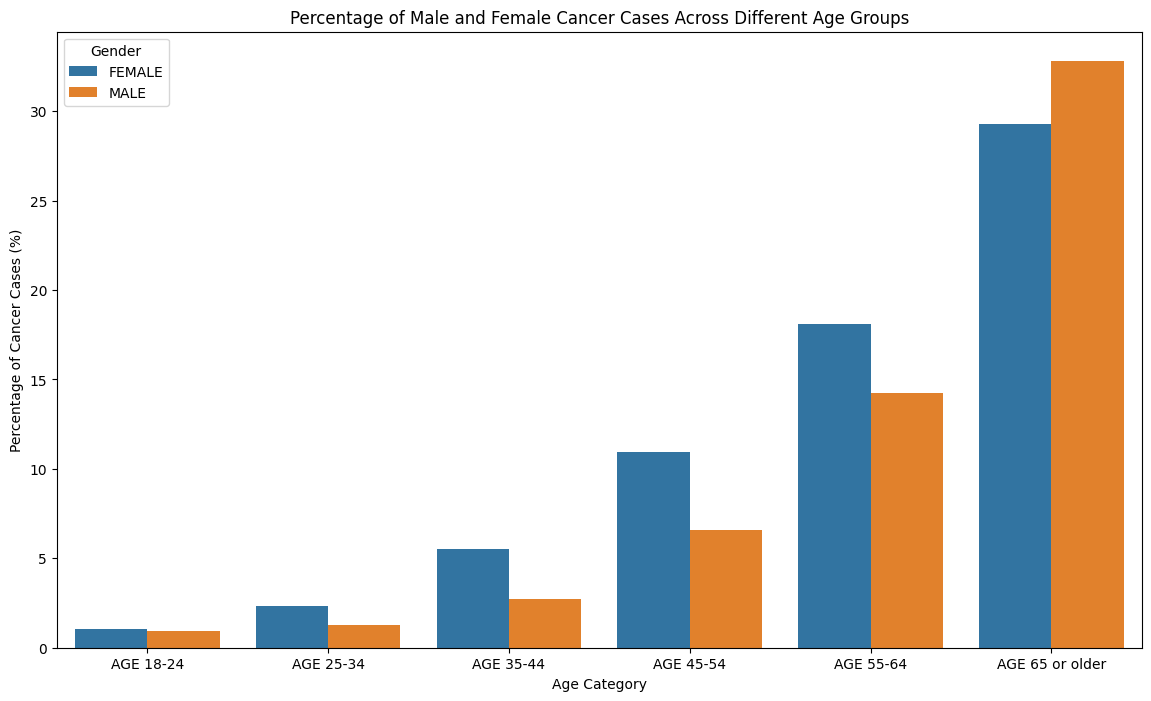

In [12]:
total_counts = eda_df.groupby(['AGE_CATEGORY', 'GENDER']).size().reset_index(name='Total_Count')
cancer_counts = cancer_df.groupby(['AGE_CATEGORY', 'GENDER']).size().reset_index(name='Cancer_Count')
merged_df = pd.merge(cancer_counts, total_counts, on=['AGE_CATEGORY', 'GENDER'])
merged_df['Percentage'] = (merged_df['Cancer_Count'] / merged_df['Total_Count']) * 100
plt.figure(figsize=(14, 8))
sns.barplot(data=merged_df, x='AGE_CATEGORY', y='Percentage', hue='GENDER')
plt.title('Percentage of Male and Female Cancer Cases Across Different Age Groups')
plt.xlabel('Age Category')
plt.ylabel('Percentage of Cancer Cases (%)')
plt.legend(title='Gender')
plt.show()

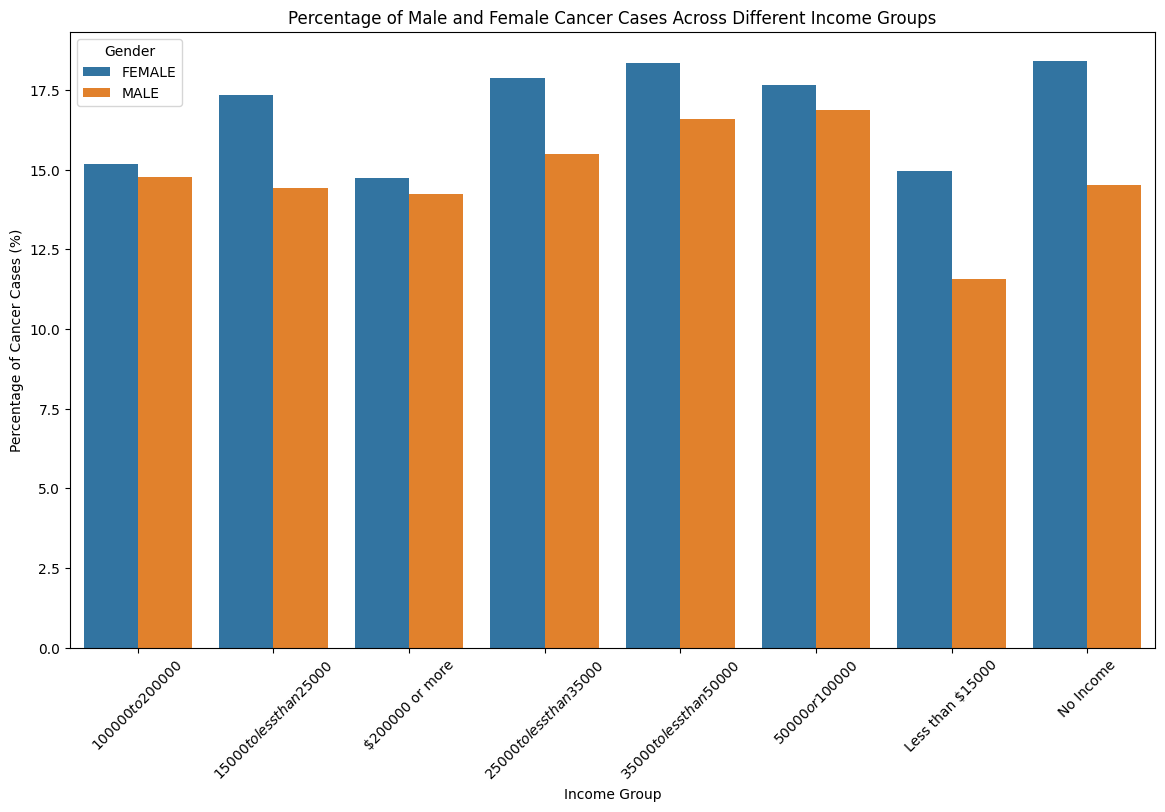

In [13]:
total_counts = eda_df.groupby(['INCOME_GRP', 'GENDER']).size().reset_index(name='Total_Count')
cancer_counts = cancer_df.groupby(['INCOME_GRP', 'GENDER']).size().reset_index(name='Cancer_Count')
merged_df = pd.merge(cancer_counts, total_counts, on=['INCOME_GRP', 'GENDER'])
merged_df['Percentage'] = (merged_df['Cancer_Count'] / merged_df['Total_Count']) * 100
plt.figure(figsize=(14, 8))
sns.barplot(data=merged_df, x='INCOME_GRP', y='Percentage', hue='GENDER')
plt.title('Percentage of Male and Female Cancer Cases Across Different Income Groups')
plt.xlabel('Income Group')
plt.xticks(rotation=45)
plt.ylabel('Percentage of Cancer Cases (%)')
plt.legend(title='Gender')
plt.show()

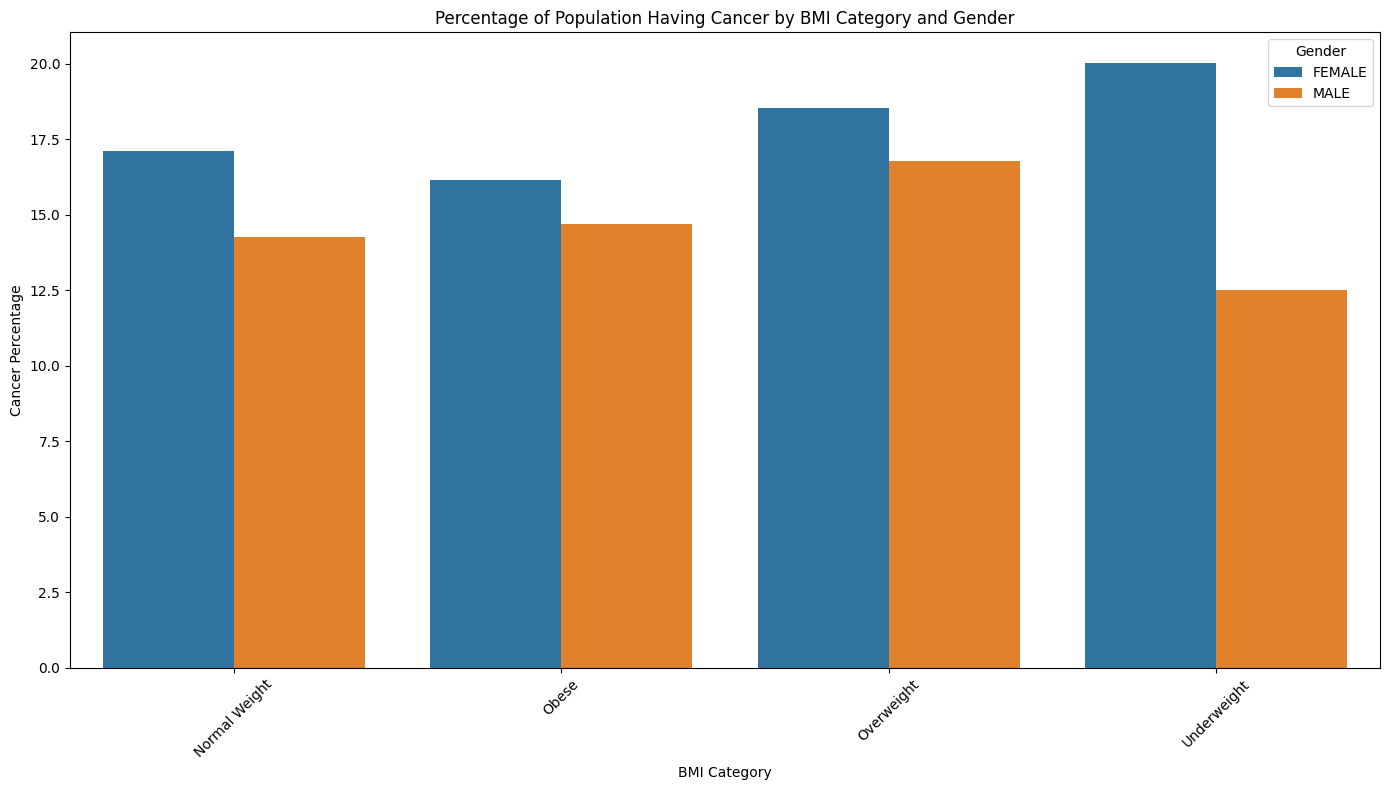

In [14]:

total_counts = eda_df.groupby(['BMI_CATEGORY', 'GENDER']).size().reset_index(name='Total_Count')
cancer_counts = cancer_df.groupby(['BMI_CATEGORY', 'GENDER']).size().reset_index(name='Cancer_Count')
merged_df = pd.merge(cancer_counts, total_counts, on=['BMI_CATEGORY', 'GENDER'])
merged_df['Percentage'] = (merged_df['Cancer_Count'] / merged_df['Total_Count']) * 100
plt.figure(figsize=(14, 8))
sns.barplot(data=merged_df, x='BMI_CATEGORY', y='Percentage', hue='GENDER')
plt.title('Percentage of Population Having Cancer by BMI Category and Gender')
plt.xlabel('BMI Category')
plt.ylabel('Cancer Percentage')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

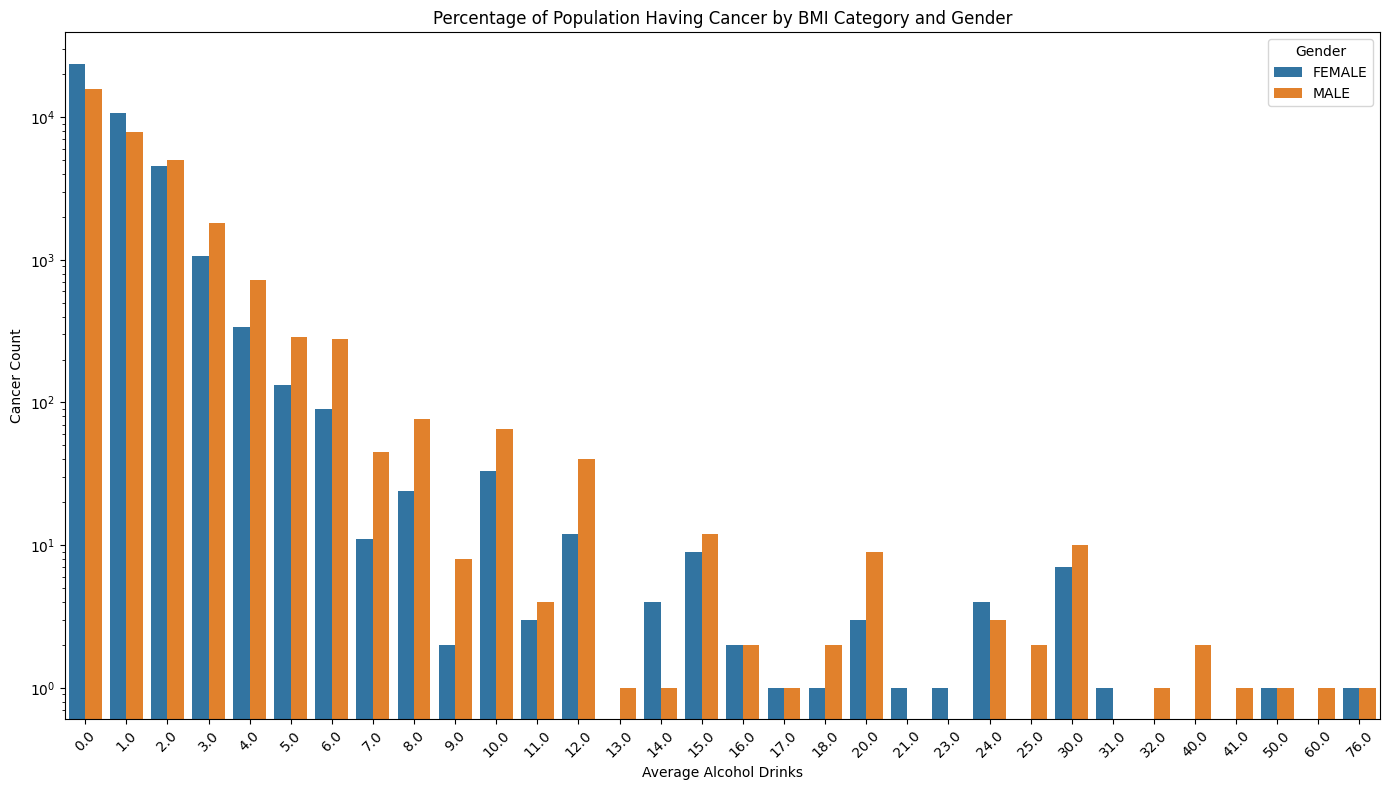

In [15]:
total_counts = eda_df.groupby(['ACG_ALC', 'GENDER']).size().reset_index(name='Total_Count')
cancer_counts = cancer_df.groupby(['ACG_ALC', 'GENDER']).size().reset_index(name='Cancer_Count')
plt.figure(figsize=(14, 8))
sns.barplot(data=cancer_counts, x='ACG_ALC', y='Cancer_Count', hue='GENDER')
plt.title('Percentage of Population Having Cancer by BMI Category and Gender')
plt.xlabel('Average Alcohol Drinks')
plt.ylabel('Cancer Count')
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

In [16]:
eda_df = eda_df.drop(columns=["YEAR", "MONTH", "DAY", "YEARMO"])

Plotting a Correlation Matrix to explain the relationships between each variable

In [17]:
import scipy.stats as ss
import numpy as np

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

corr_matrix = pd.DataFrame({col: [cramers_v(eda_df[col], eda_df[col2]) for col2 in eda_df.columns] for col in eda_df.columns}, index=eda_df.columns)

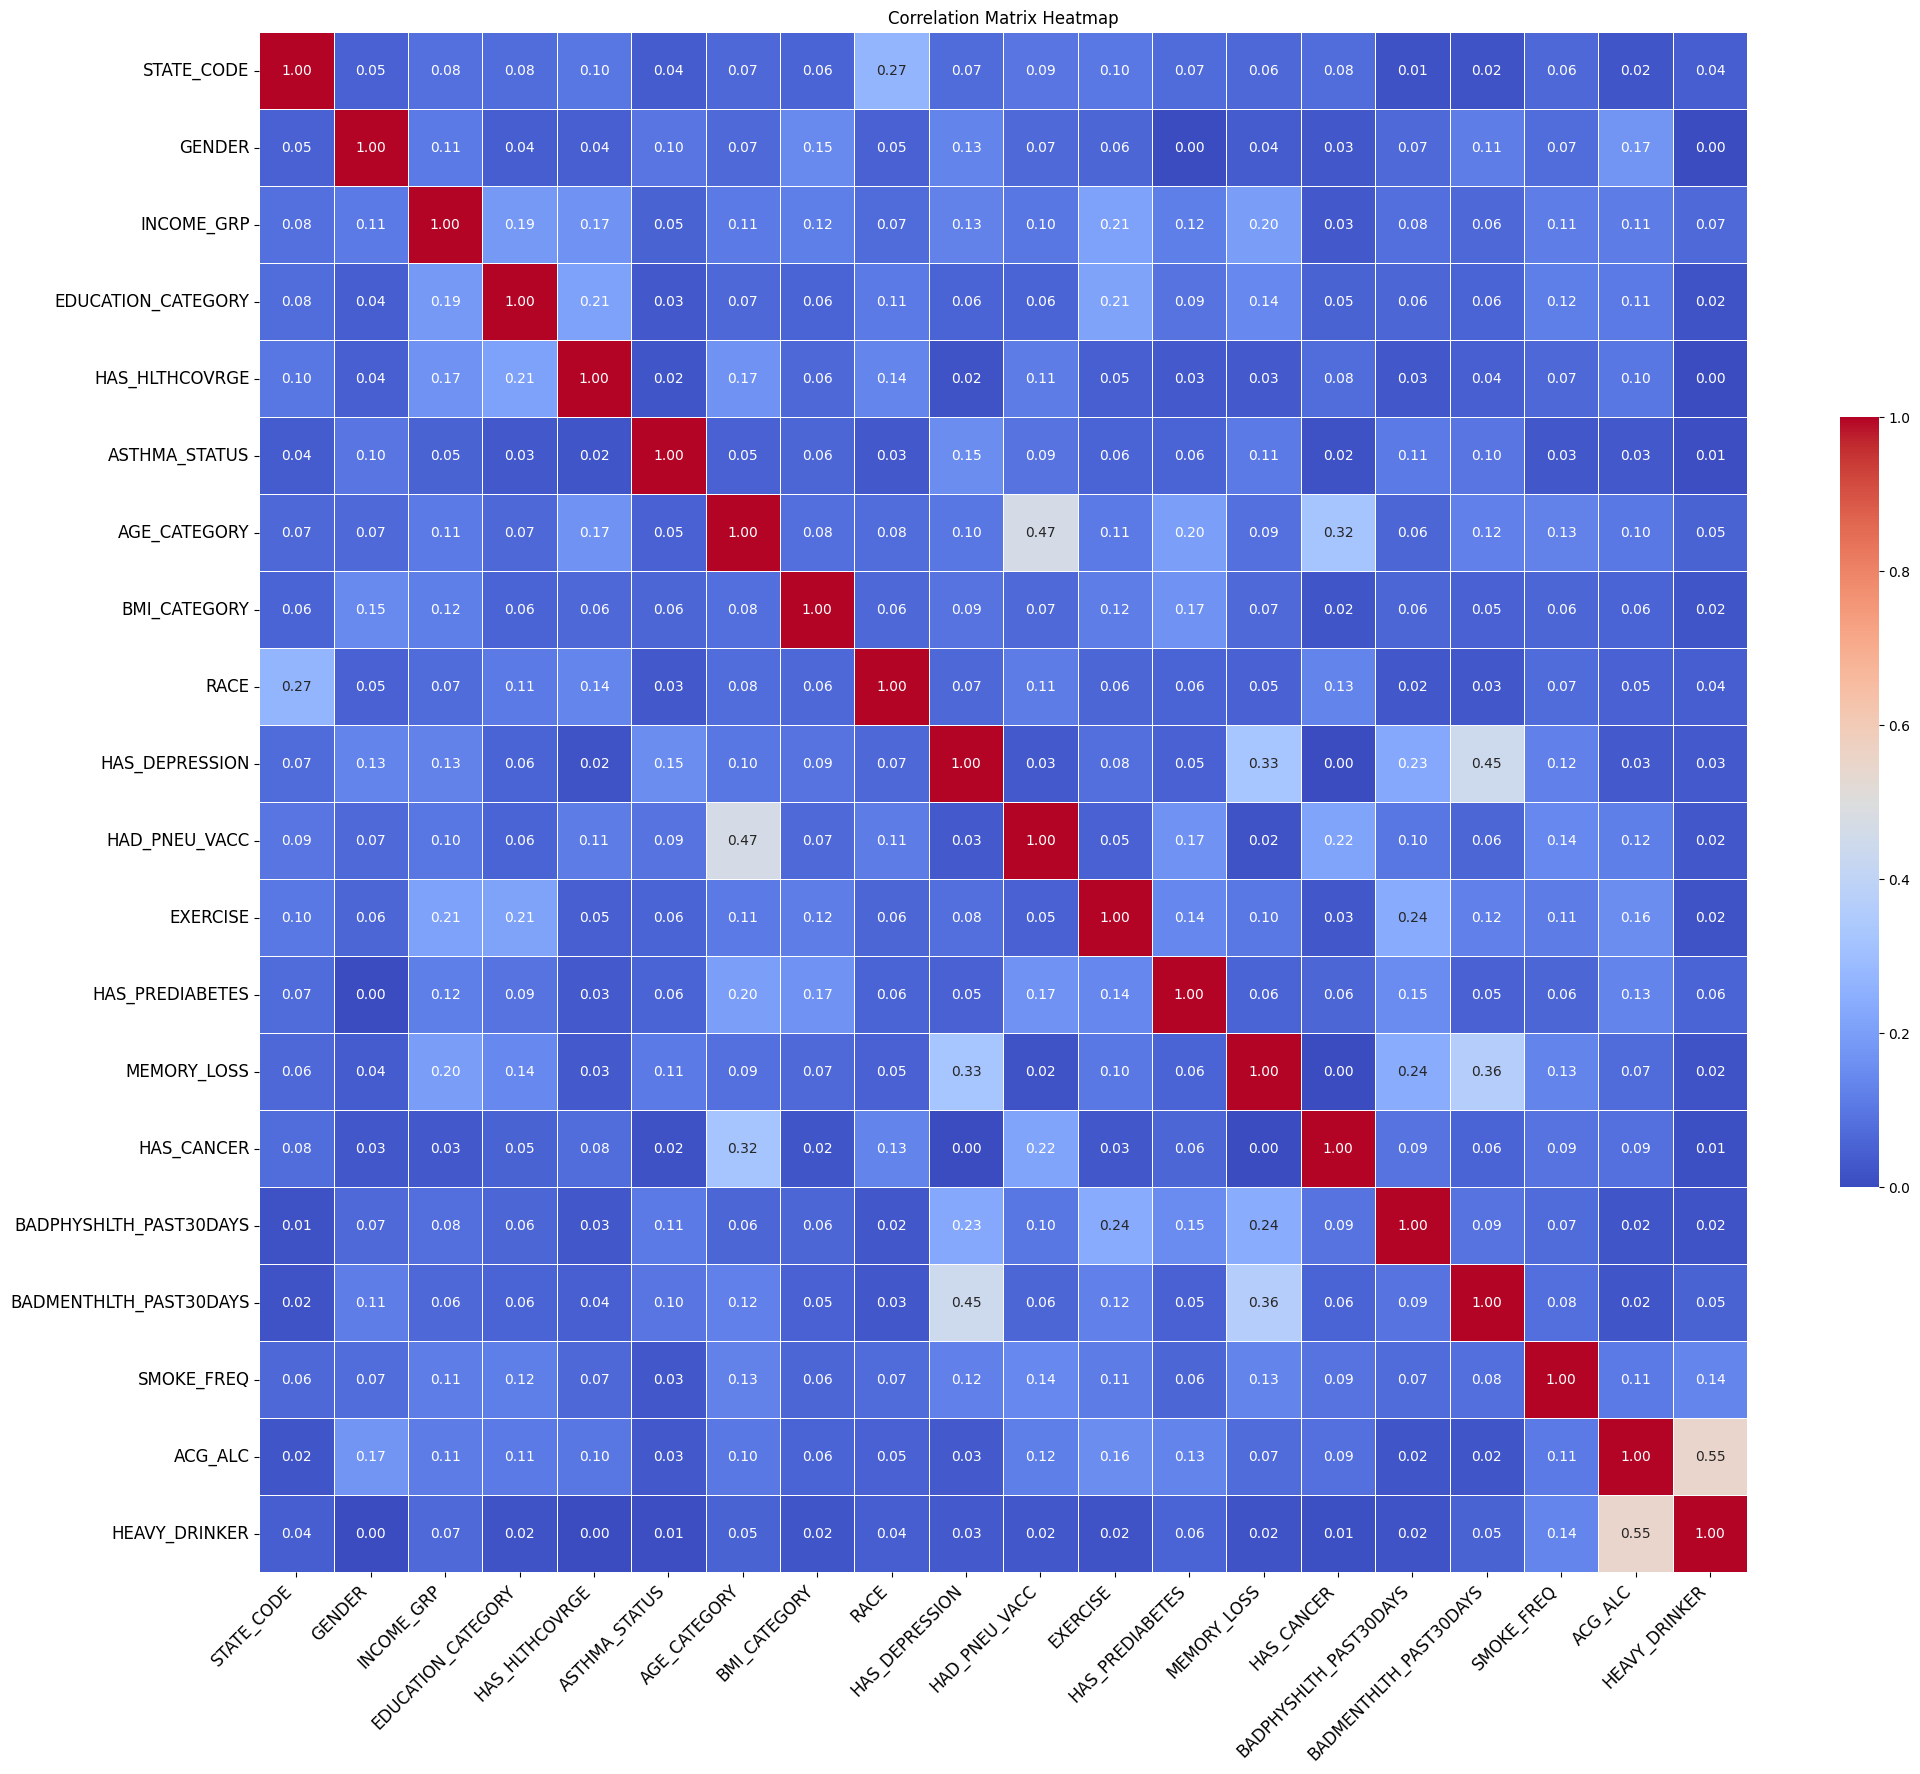

In [18]:
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, cbar_kws={'shrink': 0.5}, annot_kws={"size": 10})
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

In [20]:
eda_df

STATE_CODE  GENDER                  INCOME_GRP  \
0              AL  FEMALE                   No Income   
1              AL  FEMALE  $25000 to less than $35000   
2              AL  FEMALE          $100000 to $200000   
3              AL  FEMALE                   No Income   
4              AL  FEMALE  $25000 to less than $35000   
...           ...     ...                         ...   
445127         VI  FEMALE            Less than $15000   
445128         VI  FEMALE           $50000 or $100000   
445129         VI  FEMALE                   No Income   
445130         VI    MALE           $50000 or $100000   
445131         VI    MALE  $15000 to less than $25000   

                       EDUCATION_CATEGORY HAS_HLTHCOVRGE ASTHMA_STATUS  \
0                 College 4 years or more             No         Never   
1       Grades 12 or High School Graduate            Yes         Never   
2                 College 4 years or more            Yes         Never   
3       Grades 12 or High School Graduate             No       Current   
4               College 1 year to 3 years            Yes         Never   
...                                   ...            ...           ...   
445127  Grades 12 or High School Graduate            Yes       Current   
445128            College 4 years or more            Yes         Never   
445129  Grades 12 or High School Graduate             No         Never   
445130          College 1 year to 3 years            Yes        Former   
445131                Grades 9 through 11             No         Never   

           AGE_CATEGORY   BMI_CATEGORY              RACE HAS_DEPRESSION  \
0       AGE 65 or older  Normal Weight             White             No   
1       AGE 65 or older     Overweight             White             No   
2             AGE 55-64     Overweight             White             No   
3       AGE 65 or older  Normal Weight             White             No   
4             AGE 35-44  Normal Weight             White             No   
...                 ...            ...               ...            ...   
445127        AGE 18-24     Overweight  African American            Yes   
445128        AGE 45-54     Overweight  African American             No   
445129  AGE 65 or older    Underweight        Other Race             No   
445130  AGE 65 or older          Obese  African American             No   
445131        AGE 35-44  Normal Weight  African American             No   

       HAD_PNEU_VACC EXERCISE HAS_PREDIABETES MEMORY_LOSS HAS_CANCER  \
0                 No       No             Yes          No         No   
1                 No       No              No          No        Yes   
2                 No      Yes              No          No        Yes   
3                Yes      Yes              No          No         No   
4                Yes      Yes              No          No         No   
...              ...      ...             ...         ...        ...   
445127            No      Yes              No          No         No   
445128            No      Yes              No          No         No   
445129            No       No              No          No         No   
445130           Yes       No              No          No         No   
445131            No      Yes              No         Yes         No   

        BADPHYSHLTH_PAST30DAYS  BADMENTHLTH_PAST30DAYS SMOKE_FREQ  ACG_ALC  \
0                            0                       0         No      0.0   
1                            0                       0         No      0.0   
2                            2                       3         No      0.0   
3                            0                       0     Medium      0.0   
4                            2                       0         No      2.0   
...                        ...                     ...        ...      ...   
445127                       0                       3         No      0.0   
445128                       2             

Splitting the data into Feature dataframe and target dataframe for further processing.

In [21]:
X = eda_df[eda_df.columns.difference(['HAS_CANCER'])]
y = eda_df['HAS_CANCER']

In [22]:
y.value_counts()

HAS_CANCER
No     372332
Yes     72800
Name: count, dtype: int64

Encoding and Scaling the Categorical and Numerical data respectively using OneHotEncoder and StandardScaler

In [23]:
categorical_columns = eda_df.columns.difference( ['BADPHYSHLTH_PAST30DAYS', 'BADMENTHLTH_PAST30DAYS', 'ACG_ALC','STATE_CODE','HAS_CANCER'])
numerical_columns = ['BADPHYSHLTH_PAST30DAYS', 'BADMENTHLTH_PAST30DAYS', 'ACG_ALC']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_preprocessed = pipeline.fit_transform(X)

y_preprocessed = y.apply(lambda x : 1 if x == "Yes" else 0)

Plotting a graph to visualize the variance explained by each component. It helps in determining the number of components that are useful to explain 90% of variance and reduce the number of dimensions used to train the data.

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [90.0%] explained variance using the [42] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [22] that covers the [90.00%] explained variance.
[pca] >The PCA reduction is performed on the [42] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[22]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


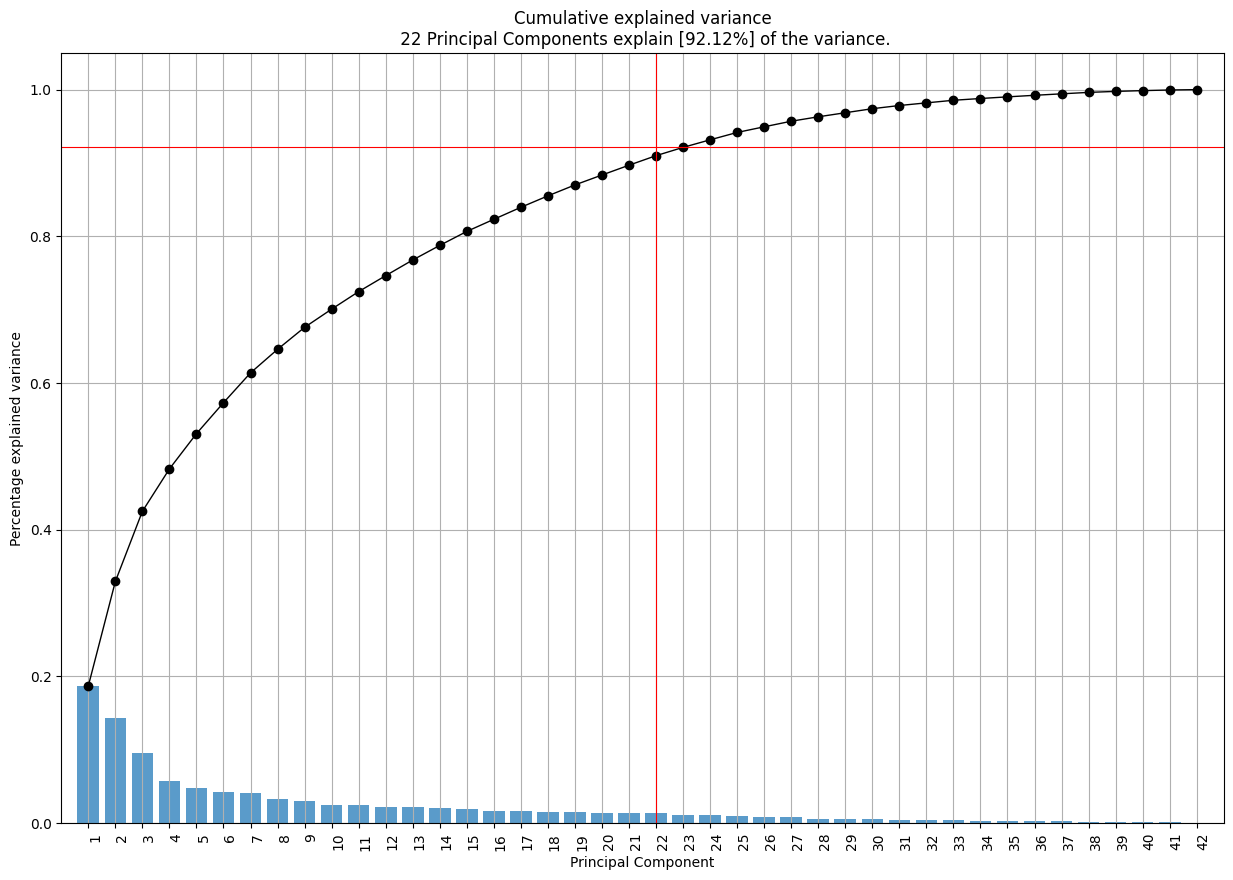

In [24]:
from pca import pca

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

X_pca_df = pd.DataFrame(X_preprocessed.toarray(), columns=feature_names)

pca_model = pca(n_components=0.9)
results = pca_model.fit_transform(X_pca_df)

fig, ax = pca_model.plot()

Splitting the data into training and testing sets with only 26 components which were used to explain 90% variance of the data. It reduced the number of components significantly and reduced the time to train the models.

In [25]:
n_components = 22
X_pca = results["PC"]
# y = eda_df['HAS_CANCER']

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_preprocessed, test_size=0.2, random_state=42, stratify=y_preprocessed)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

Listing all the models as dictionary objects to evaluate all of them at once

In [26]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'CatBoost' : CatBoostClassifier(random_state=42, eval_metric='Logloss', verbose=0),
    'Decision Tree' : DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
}

A simple function that helps to evaluate the metrics of any model and displays the confusion matrix to understand the balance of the predictions.

In [28]:
def evaluate_model(y_test, y_pred, model_name, disease_name):
    print(f"{model_name} - Precision: {precision_score(y_test, y_pred, average='weighted')}")
    print(f"{model_name} - Recall: {recall_score(y_test, y_pred, average='weighted')}")
    print(f"{model_name} - Classification Report:\n {classification_report(y_test, y_pred)}")
    print(f"{model_name} - Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}\n")
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    print(f"{model_name} - Confusion Matrix (Percentages):\n {cm_percent}\n")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=["None", disease_name])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix (Percentages)')
    plt.show()

Running the pipeline to train all the models and evaluating them based on the results

Cancer Prediction
Logistic Regression - Precision: 0.8308095562951622
Logistic Regression - Recall: 0.6675502937311153
Logistic Regression - Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.65      0.77     74467
           1       0.30      0.77      0.43     14560

    accuracy                           0.67     89027
   macro avg       0.62      0.71      0.60     89027
weighted avg       0.83      0.67      0.71     89027

Logistic Regression - Confusion Matrix:
 [[48236 26231]
 [ 3366 11194]]

Logistic Regression - Confusion Matrix (Percentages):
 [[64.77500101 35.22499899]
 [23.11813187 76.88186813]]



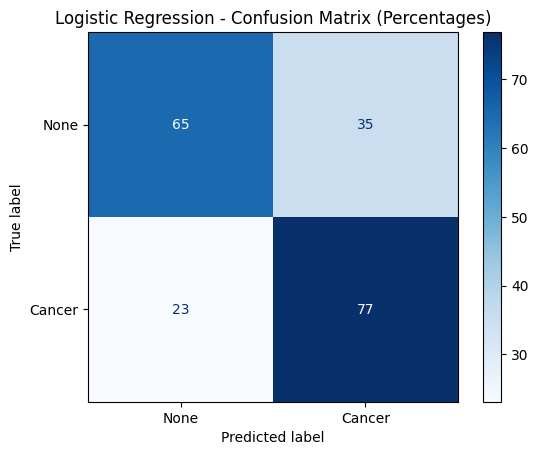

XGBoost - Precision: 0.8239217946474289
XGBoost - Recall: 0.677378772731868
XGBoost - Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.67      0.78     74467
           1       0.30      0.73      0.42     14560

    accuracy                           0.68     89027
   macro avg       0.61      0.70      0.60     89027
weighted avg       0.82      0.68      0.72     89027

XGBoost - Confusion Matrix:
 [[49694 24773]
 [ 3949 10611]]

XGBoost - Confusion Matrix (Percentages):
 [[66.73291525 33.26708475]
 [27.12225275 72.87774725]]



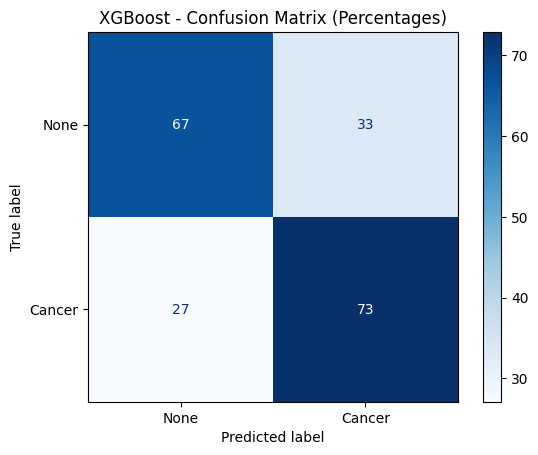

CatBoost - Precision: 0.820835380868354
CatBoost - Recall: 0.6854549743336291
CatBoost - Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.68      0.78     74467
           1       0.30      0.71      0.42     14560

    accuracy                           0.69     89027
   macro avg       0.61      0.69      0.60     89027
weighted avg       0.82      0.69      0.72     89027

CatBoost - Confusion Matrix:
 [[50744 23723]
 [ 4280 10280]]

CatBoost - Confusion Matrix (Percentages):
 [[68.1429358 31.8570642]
 [29.3956044 70.6043956]]



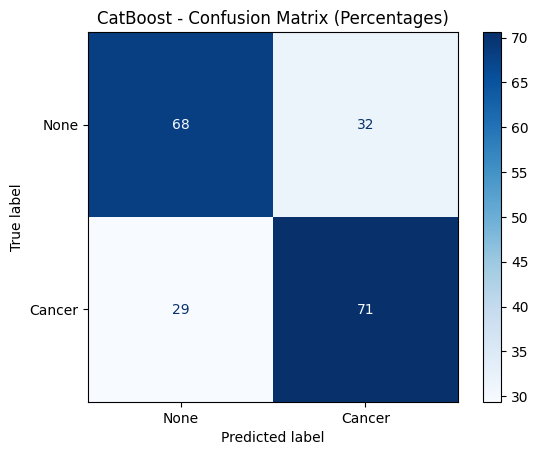

Decision Tree - Precision: 0.7745621670486504
Decision Tree - Recall: 0.708537859301111
Decision Tree - Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.76      0.81     74467
           1       0.26      0.44      0.33     14560

    accuracy                           0.71     89027
   macro avg       0.57      0.60      0.57     89027
weighted avg       0.77      0.71      0.73     89027

Decision Tree - Confusion Matrix:
 [[56671 17796]
 [ 8152  6408]]

Decision Tree - Confusion Matrix (Percentages):
 [[76.10216606 23.89783394]
 [55.98901099 44.01098901]]



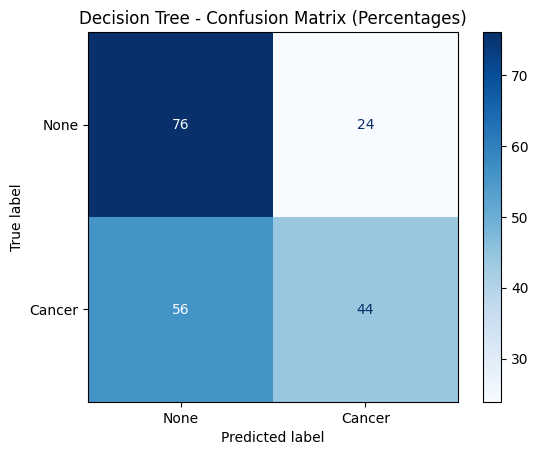

Random Forest - Precision: 0.7883479306173865
Random Forest - Recall: 0.746829613488043
Random Forest - Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.81      0.84     74467
           1       0.31      0.45      0.37     14560

    accuracy                           0.75     89027
   macro avg       0.60      0.63      0.60     89027
weighted avg       0.79      0.75      0.76     89027

Random Forest - Confusion Matrix:
 [[59964 14503]
 [ 8036  6524]]

Random Forest - Confusion Matrix (Percentages):
 [[80.52425907 19.47574093]
 [55.19230769 44.80769231]]



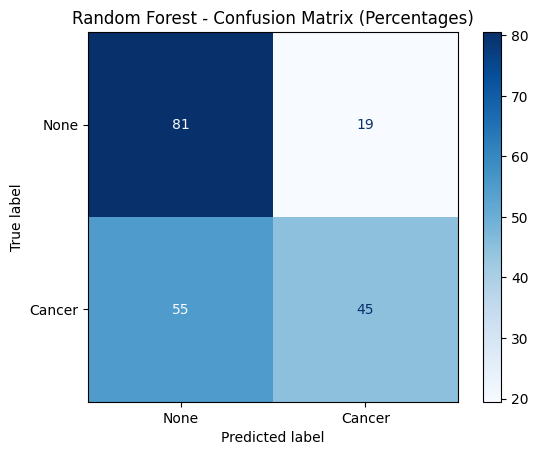

In [29]:
print("Cancer Prediction")
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_model(y_test, y_pred, model_name, "Cancer")

In [30]:
X_train

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0      -0.697082 -0.113615  0.294792  1.319487  0.357186  0.189706 -0.234398   
1      -0.686840 -0.736902 -0.152677  0.076782  0.895437  0.840894  0.290314   
2       0.151268  0.799749 -0.863414  0.009253  0.745292 -0.652184 -0.335955   
3      -0.846460 -0.014210 -0.191762 -0.729669  0.415363 -0.030780 -0.573308   
4      -0.691409  0.316625  0.090137 -0.244854 -0.336406  0.931847 -0.147507   
...          ...       ...       ...       ...       ...       ...       ...   
595725 -0.835514 -0.218665  0.077346  0.075984  0.965302  0.784390  0.184317   
595726  1.374383 -0.736862  1.953941 -0.000131  0.647376 -0.874890 -1.055821   
595727  0.110576 -0.550619  1.109123  0.892702  0.699594 -0.013557 -1.075357   
595728  1.250996 -0.333485 -0.092875 -0.015618  1.153874  0.737265  0.255879   
595729 -0.495139  0.557297 -0.195058 -0.751151  0.389676  0.198158 -0.345292   

             PC8       PC9      PC10  ...      PC13      PC14      PC15  \
0       0.277117 -0.488405  0.246799  ...  0.161557  0.045558 -0.109166   
1       0.499027  0.461942 -0.371544  ...  0.127418  0.391019  0.333804   
2       0.513308 -0.685789  0.330528  ... -0.374385  0.686794 -0.335383   
3       0.300449 -0.741950 -0.414133  ... -0.104762 -0.167208 -0.135461   
4       0.369447  0.080093 -0.997476  ...  0.319905  0.270728 -0.202650   
...          ...       ...       ...  ...       ...       ...       ...   
595725  0.185246  0.055045 -0.094212  ...  0.163386 -0.262130 -0.186765   
595726 -0.207475 -0.069479  0.252195  ...  0.351471  1.141460 -0.039362   
595727 -0.754746  0.114034  0.116001  ...  0.114235  0.023910 -0.045054   
595728  0.088892  0.060914 -0.058416  ...  0.449649 -0.178387 -0.030358   
595729  0.677197 -0.052371  0.008426  ... -0.153391  0.417834 -0.320400   

            PC16      PC17      PC18      PC19      PC20      PC21      PC22  
0      -0.088496  0.016355 -0.143933  0.507795 -0.111187 -0.105506  0.153848  
1      -0.259184 -0.577157 -0.335614 -0.211510 -0.110378 -0.144966 -0.026346  
2      -0.064519 -0.502077  0.016640 -0.222111 -0.028707 -0.128111 -0.135992  
3      -0.142284  0.059215  0.013222 -0.048499 -0.266647 -0.167734  0.181757  
4       0.326317 -0.116305 -0.227457  0.485424  0.366088  0.116613 -0.467819  
...          ...       ...       ...       ...       ...       ...       ...  
595725 -0.071082  0.095314 -0.270618  0.010178 -0.221609 -0.028141  0.130239  
595726 -0.088337  0.587412 -0.525220  0.102803 -0.284669 -0.149752  0.377233  
595727 -0.035302  0.018582 -0.191456 -0.078337  0.067673  0.025145 -0.293465  
595728 -0.001010  0.867432  0.046079  0.074237 -0.718533  0.388715 -0.003304  
595729 -0.322013 -0.476689 -0.193476 -0.193404 -0.373411 -0.248314  0.228827  

[595730 rows x 22 columns]

Lime Tabular Explainer is a library that helps you to visualize the factors that responsible for prediction of each data point.

In [31]:
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out()[:26],
    class_names=["None", "HAS_CANCER"],
    mode='classification',
    random_state=42
)

i = 10000
instance = np.array(X_test)[i]
actual_label = y_test.values[i]
predicted_label = models["XGBoost"].predict([instance])[0]


print(f"Actual label: {actual_label}")
print(f"Predicted label: {predicted_label}")
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn= models["XGBoost"].predict_proba,
    num_features=10
)

exp.show_in_notebook(show_table=True, show_all=True)


Actual label: 1
Predicted label: 1


In [32]:
i = 1000
instance = np.array(X_test)[i]
actual_label = y_test.values[i]
predicted_label = models["XGBoost"].predict([instance])[0]


print(f"Actual label: {actual_label}")
print(f"Predicted label: {predicted_label}")
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn= models["XGBoost"].predict_proba,
    num_features=10
)

exp.show_in_notebook(show_table=True, show_all=True)

Actual label: 0
Predicted label: 0


Performing a grid search using catboost classifier to tune the hyper parameters

In [35]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
log_reg = LogisticRegression(random_state=42, max_iter=1000)

grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.779624997901734


GridSearch - Logistic Regression - Precision: 0.8308142852291891
GridSearch - Logistic Regression - Recall: 0.6675727588259741
GridSearch - Logistic Regression - Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.65      0.77     74467
           1       0.30      0.77      0.43     14560

    accuracy                           0.67     89027
   macro avg       0.62      0.71      0.60     89027
weighted avg       0.83      0.67      0.71     89027

GridSearch - Logistic Regression - Confusion Matrix:
 [[48238 26229]
 [ 3366 11194]]

GridSearch - Logistic Regression - Confusion Matrix (Percentages):
 [[64.77768676 35.22231324]
 [23.11813187 76.88186813]]



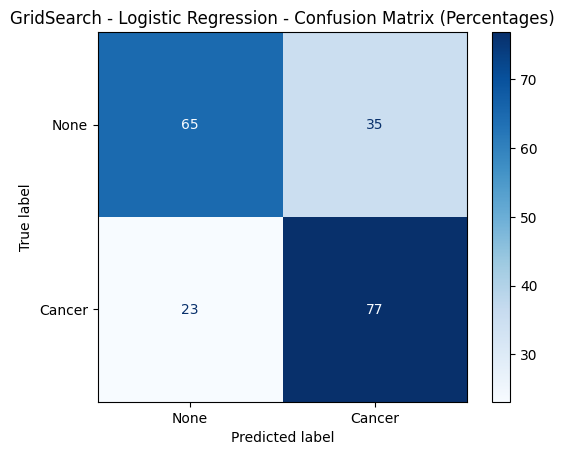

In [34]:
y_pred_lr = grid_search.best_estimator_.predict(X_test)
evaluate_model(y_test, y_pred_lr, "GridSearch - Logistic Regression", "Cancer")

The Accuracy is less than what we got previously. Hence we assume that the previous model is the best for given data.

In [59]:
synthesized_dict = {
    'GENDER': ['FEMALE', 'MALE', 'MALE'],
    'STATE_CODE': ['AZ', 'NY', 'IN'],
    'RACE': ['White', 'African American', 'White'],
    'INCOME_GRP': ['$15000 to less than $25000', 'No Income', '$100000 to $200000'],
    'EDUCATION_CATEGORY': ['Grades 12 or High School Graduate', 'Grades 9 through 11', 'College 4 years or more'],
    'HAS_HLTHCOVRGE': ['No', 'Yes', 'Yes'],
    'ASTHMA_STATUS': ['Former', 'Current', 'Never'],
    'AGE_CATEGORY': ['AGE 18-24', 'AGE 55-64', 'AGE 35-44'],
    'BMI_CATEGORY': ['Underweight', 'Overweight', 'Overweight'],
    'HAS_DEPRESSION': ['No', 'Yes', 'Yes'],
    'HAD_PNEU_VACC': ['Yes', 'No', 'Yes'],
    'EXERCISE': ['Yes', 'No', 'No'],
    'HAS_PREDIABETES': ['No', 'No', 'Yes'],
    'MEMORY_LOSS': ['No', 'Yes', 'No'],
    'BADPHYSHLTH_PAST30DAYS': [3, 25, 15],
    'BADMENTHLTH_PAST30DAYS': [20, 1, 6],
    'SMOKE_FREQ': ['High', 'Medium', 'Low'],
    'ACG_ALC': [4, 0, 0],
    'HEAVY_DRINKER': ['Yes', 'No', 'No'],
    'HAS_CANCER': ['No', 'Yes', 'No'],
}

syn_df = pd.DataFrame(synthesized_dict)

X_syn = syn_df[syn_df.columns.difference(["HAS_CANCER"])]
Y_syn = syn_df["HAS_CANCER"]

In [60]:
X_syn_processed = pipeline.transform(X_syn)
X_syn_pca = pca_model.transform(X_syn_processed)
X_syn_pca

[pca] >Column labels are auto-completed.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[22]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
mapped  1.327210  1.838672 -0.887263  0.696564 -0.321170  0.518896  0.549607   
mapped  1.714681 -0.826612  1.644863 -0.620613 -0.649588 -1.126565  0.290343   
mapped  1.169182 -0.551095  0.749674  0.581583  0.614339 -0.984010 -0.334553   

             PC8       PC9      PC10  ...      PC13      PC14      PC15  \
mapped  0.429326 -0.270181 -0.173554  ...  0.676807  0.261735  0.020311   
mapped  0.424718  0.334373 -0.110820  ... -0.094191  0.827129  1.012095   
mapped -0.033620  0.236112  0.061710  ... -0.459875  0.049307  0.708306   

            PC16      PC17      PC18      PC19      PC20      PC21      PC22  
mapped  0.226613  1.245473 -0.280135  0.149984 -0.373176  0.057111  0.477922  
mapped -0.475601 -0.291486  0.140308  0.282816 -0.205593 -0.407196 -0.462614  
mapped  0.694560 -0.574282 -0.489241 -0.315631  0.332461  0.310456  0.637057  

[3 rows x 22 columns]

In [62]:
y_syn_pred = models["Logistic Regression"].predict(X_syn_pca)
y_syn_pred_labels = ["No" if x == 0 else "Yes" for x in y_syn_pred]
print(f"Actual Labels are {Y_syn.tolist()}")
print(f"Predicted Labels are {y_syn_pred_labels}")

Actual Labels are ['No', 'Yes', 'No']
Predicted Labels are ['No', 'No', 'No']
